# Midterm part 2: Instructions

<img src="https://pbs.twimg.com/profile_images/935574083256819713/vORBliVR_400x400.jpg" width="100" height="100">


In this part of the exam, you will endeavor to build a model to predict MPI rates by country based on the loan and electricty consumption information known about them. MPI stands for multidimensional poverty index, where the the higher the number, the more impoverished the country. The index is typically expressed as a percent that ranges from 0 to 100%. 

You can use outside resources (e.g. StackOverflow, past homeworks and Labs) for this portion of the exam.

## Data preparation
#### Step 1: import libaries
Always import all the libraries at the beginning of your code. You may add libraries as needed.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Packages for checking assumptions
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import random
from statsmodels.formula.api import ols

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

#### Step 2: import data
Import the MPI, country mapper, and loans data.

In [4]:
MPI_data = pd.read_csv("MPI_data_poverty.csv", encoding="ISO-8859-1")
loan_data = pd.read_csv("loans_midterm.csv")
country_mapper = pd.read_csv("country_mapper.csv")

#### Step 3: clean data
Look for 2 types of data anomalies in the MPI poverty data to clean. Please comment your approach to cleaning the data and explain your rationale.

In [96]:
"""Clean the dataframe and save as MPI_data, i.e. do not create new dataframe names
for autograding purposes."""

### BEGIN SOLUTION
# Included three types of error - negative MPI rates and over 100%. They are typos we can check.
MPI_data.loc[(MPI_data['MPI_Country'] < 0), "MPI_Country"] = 0.295
MPI_data.loc[(MPI_data['MPI_Country'] > 1), "MPI_Country"] = 0.1520

# ...bad ISO country codes. They are typos we can check.
MPI_data.loc[MPI_data['ISO country code'] == 'AF', "ISO country code"] = 'AFG'
MPI_data.loc[MPI_data['ISO country code'] == 'UG', "ISO country code"] = 'UGA'
MPI_data.loc[MPI_data['ISO country code'] == 'UZ', "ISO country code"] = 'UZB'

# ...and duplicates. We can just drop the duplicates
MPI_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
MPI_data.drop_duplicates(inplace = True)
### END SOLUTION

'Clean the dataframe and save as MPI_data, i.e. do not create new dataframe names\nfor autograding purposes.'

In [97]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
count = 0
if (len(MPI_data.loc[(MPI_data['MPI_Country'] < 0)]) == 0): count += 1
if (len(MPI_data.loc[(MPI_data['MPI_Country'] > 1)]) == 0): count += 1
if (len(MPI_data.loc[MPI_data['ISO country code'] == 'AF']) == 0): count += 1
if (len(MPI_data.loc[MPI_data['ISO country code'] == 'UG']) == 0): count += 1
if (len(MPI_data.loc[MPI_data['ISO country code'] == 'UZ']) == 0): count += 1
if (len(MPI_data) == 994): count += 1

assert count > 3
### END HIDDEN TESTS

## Exploratory analysis

#### Step 4: understand the MPI data
Manipulate the MPI data to understand the:
* top 10 countries with the highest MPI index
* a visual distribution of MPI in all the countries
* mean and standard deviation of MPI in all the countries

In [14]:
"""Find the top 10 countries with the highest MPI index and save in an ordered list called 
top_countries, where the first country is the poorest and the last is the wealthest."""

### BEGIN SOLUTION
# Build an index of only the relevant countries to remove duplicates in joining
MPI_countries = MPI_data.groupby(['Country', 'ISO country code'])['MPI_Country', 'popDensity', 'AvgNightLight', 'Conflicts_total'].mean().reset_index().sort_values("MPI_Country", ascending = False)
top_countries = list(MPI_countries[:10]['Country'])
print(top_countries)
### END SOLUTION

'Find the top 10 countries with the highest MPI index and save in an ordered list called \ntop_countries, where the first country is the poorest and the last is the wealthest.'

['Niger', 'South Sudan', 'Chad', 'Burkina Faso', 'Ethiopia', 'Sierra Leone', 'Guinea', 'Mali', 'Burundi', 'Central African Republic']


In [15]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert top_countries == ['Niger', 'South Sudan', 'Chad', 'Burkina Faso', 'Ethiopia', 'Sierra Leone', 'Guinea', 'Mali', 'Burundi', 'Central African Republic']
### END HIDDEN TESTS

'Visualize a distribution of MPI in all the countries'

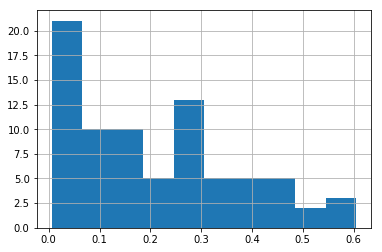

In [98]:
"""Visualize a distribution of MPI in all the countries"""

### BEGIN SOLUTION
MPI_countries['MPI_Country'].hist()
### END SOLUTION

In [99]:
"""Get the mean and standard deviation of the MPI in all the countries. Save as variables called mean
and std."""

### BEGIN SOLUTION
print(MPI_countries.describe())
mean = 0.203494
std = 0.163407
### END SOLUTION

'Get the mean and standard deviation of the MPI in all the countries. Save as variables called mean\nand std.'

       MPI_Country   popDensity  AvgNightLight  Conflicts_total
count    79.000000    79.000000      79.000000        79.000000
mean      0.203494   831.125308      15.152621         2.505297
std       0.163407  1225.970956      13.915057         8.669156
min       0.006000     6.104167       0.000000         0.000000
25%       0.053000    92.937319       4.967949         0.000000
50%       0.175000   408.345650      10.400000         0.000000
75%       0.305000   879.148589      21.952381         1.258929
max       0.605000  5339.504063      53.000000        70.176471


In [100]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert abs(mean - 0.203494) < 0.001
assert abs(std - 0.163407) < 0.001
### END HIDDEN TESTS

## Building our model

#### Step 5: merge data
Merge the two data sets on an appropriate column or columns using the country code mapper provided.

In [101]:
"""Name the final merged data set data_final"""

### BEGIN SOLUTION
# merge the mapper with the MPI countries data
MPI_data_ISO = pd.merge(MPI_countries, country_mapper, on = ['ISO country code'], how = 'left')
data_final = pd.merge(loan_data, MPI_data_ISO, on = ['location_country_code'], how = 'left')
### END SOLUTION

'Name the final merged data set data_final'

#### Step 6: test results
Run code to understand if the merge worked and makes sense.

In [103]:
"""This section is not graded but added to encourage habitual testing of your code"""

### BEGIN SOLUTION
print(len(MPI_data), len(loan_data), len(data_final))
data_final.groupby(['Country', 'location_country_code', 'ISO country code']).size().reset_index()
### END SOLUTION

'This section is not graded but added to encourage habitual testing of your code'

994 5618 5618


,Country,location_country_code,ISO country code,0
0,Benin,BJ,BEN,200
1,Burkina Faso,BF,BFA,200
2,Burundi,BI,BDI,200
3,Cameroon,CM,CMR,200
4,"Congo, Democratic Republic of the",CD,COD,400
5,"Congo, Republic of",CG,COG,200
6,Cote d'Ivoire,CI,CIV,200
7,Egypt,EG,EGY,200
8,Ghana,GH,GHA,200
9,Kenya,KE,KEN,200


In [104]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert len(data_final) == len(loan_data)
assert data_final.loc[data_final['location_country_code'] == 'BF']['ISO country code'].unique()[0]\
        == 'BFA'
assert data_final.loc[data_final['location_country_code'] == 'CG']['ISO country code'].unique()[0]\
        == 'COG'
assert abs(data_final.loc[data_final['location_country_code'] == 'ZW']['MPI_Country'].unique()[0]\
        - 0.152) < 0.001
assert abs(data_final.loc[data_final['location_country_code'] == 'TZ']['MPI_Country'].unique()[0]\
        - 0.284) < 0.001
### END HIDDEN TESTS

#### Step 7: test assumptions that apply before building the model
List assumptions that apply for a linear regression model and how you can fix them if they are violated.


* **The error is homoscedatic (equal variance) against independent / dependent variable:** Graph the errors and if not homoscedastic, it can potentially be solved with a transformation of the dependent variable
* **Error is normally distributed:** Similar to the above, a transformation may fix it
* **There is no multicollinearity between the independent variables:** Check the correlation between independent variables and remove those that are highly correlated
* **The continuous independent and dependent variables are linearly related:** Transform variables for a linear relationship
* **The samples of data are independently and randomly sampled from the population:** Re-collect data in a random way

There are two assumptions that should be tested before building a linear regression model. Assume the two independent variables will be sector and average night light, and the dependent variable is the country's MPI.

'Test one of these assumptions. Set assumption_one = True if it passed and False if it did not'

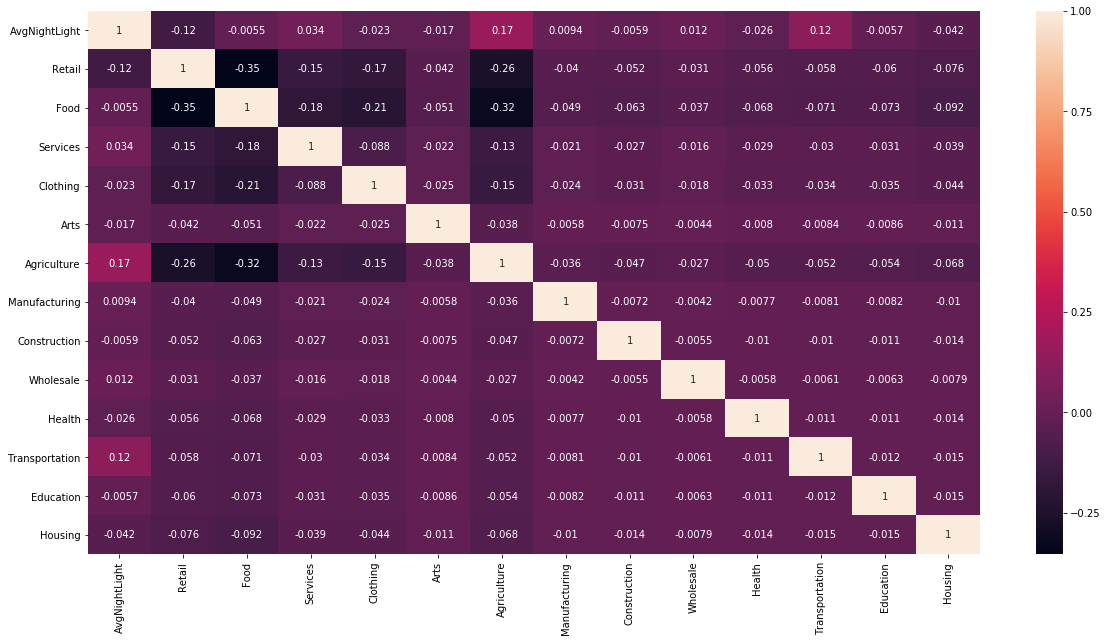

In [134]:
"""Test one of these assumptions. Set assumption_one = True if it passed and False if it did not""" 

### BEGIN SOLUTION
# Make dummy variable columns for the sectors
data_final_model = data_final.join(pd.get_dummies(data_final['sector']))
x_columns = ['AvgNightLight', 'Retail', \
             'Food', 'Services', 'Clothing', 'Arts', 'Agriculture', 'Manufacturing', 'Construction',\
             'Wholesale', 'Health', 'Transportation', 'Education', 'Housing']

# Test correlations for multicollinearity -- good
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data_final_model[x_columns].corr(), annot = True)
assumption_one = True
### END SOLUTION

'Test the second of these assumptions'

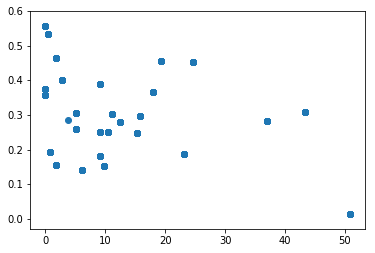

In [135]:
"""Test the second of these assumptions""" 

### BEGIN SOLUTION
# Test the linear relationship between average night light and MPI -- good
plt.scatter(y = data_final_model['MPI_Country'], x = data_final_model['AvgNightLight'])
assumption_two = False
### END SOLUTION

In [116]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert (assumption_two == False and assumption_one == True) or \
        (assumption_two == True and assumption_one == False)
### END HIDDEN TESTS

Based on these tests, we will transform one of our independent variables. Create a feature called AvgNightLight_cuberoot that is equal to the cuberoot of the feature AvgNightLight.

In [136]:
""""Name the dataframe we will be using for the linear regression model data_final_model"""

### BEGIN SOLUTION
# Create column equal to the cuberoot of AvgNightLight
data_final_model['AvgNightLight_cuberoot'] = data_final_model['AvgNightLight'] ** (1/3)
### END SOLUTION

'"Name the dataframe we will be using for the linear regression model data_final_model'

In [137]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert data_final_model['AvgNightLight_cuberoot'].equals(data_final_model['AvgNightLight'] ** (1/3))
### END HIDDEN TESTS

#### Step 8: Build a linear regression model to predict MPI
Use the following independent variables:
* AvgNightLight_cuberoot
* Sector

In [146]:
"""Use random state 0 when splitting training and test data 0.8/0.2, and add a constant to 
the linear regression."""

### BEGIN SOLUTION
# Define our dependent variable
y_column = 'MPI_Country'
y = data_final_model[y_column]

# Define  our independent variables
x_columns = ['AvgNightLight_cuberoot', 'Retail', \
             'Food', 'Services', 'Clothing', 'Arts', 'Agriculture', 'Manufacturing', 'Construction',\
             'Wholesale', 'Health', 'Transportation', 'Education', 'Housing']
X = data_final_model[x_columns]

# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build the model
X2 = sm.add_constant(X_train)
model = sm.OLS(y_train, X2)
model2 = model.fit()
print(model2.summary())
### END SOLUTION

'Use random state 0 when splitting training and test data 0.8/0.2, and add a constant to \nthe linear regression.'

                            OLS Regression Results                            
Dep. Variable:            MPI_Country   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     137.8
Date:                Wed, 10 Oct 2018   Prob (F-statistic):               0.00
Time:                        22:30:15   Log-Likelihood:                 3816.0
No. Observations:                4494   AIC:                            -7602.
Df Residuals:                    4479   BIC:                            -7506.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [142]:
"""Save the R-squared for the model built on training data as r2_training. Is this a good model? 
Change the boolean to reflect your opinion"""

### BEGIN SOLUTION
r2_training = 0.301
good_model = False
### END SOLUTION
r2_training = 0
good_model = True

'Save the R-squared for the model built on training data as r2_training. Is this a good model? \nChange the boolean to reflect your opinion'

In [143]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert abs(r2_training - 0.301) < 0.001
### END HIDDEN TESTS

In [144]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert good_model == False
### END HIDDEN TESTS

'To understand the model, plot AvgNightLight_cuberoot and the MPI country true values\nand predicted values'

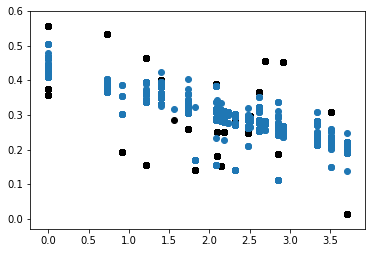

In [147]:
"""To understand the model, plot AvgNightLight_cuberoot and the MPI country true values
and predicted values"""

### BEGIN SOLUTION
# Plot the results of the linear regression
predictions_train = model2.predict(X2)
plt.scatter(X_train['AvgNightLight_cuberoot'], y_train, color = 'black')
plt.scatter(X_train['AvgNightLight_cuberoot'], predictions_train)
plt.show()
### END SOLUTION

## Model evaluation

#### Step 9: test the model for accuracy

In [121]:
"""Save the r2 and mse values to variables named r2 and mse"""

### BEGIN SOLUTION
X2_test = sm.add_constant(X_test)
predictions_test = model2.predict(X2_test)

r2 = r2_score(y_test, predictions_test)
mse = mean_absolute_error(y_test, predictions_test)
### END SOLUTION

'Save the r2 and mse values to variables named r2 and mse'

In [122]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert abs(r2 - 0.2414173689582232) < 0.001
assert abs(mse - 0.08427961305838927) < 0.001
### END HIDDEN TESTS

#### Step 10: test assumptions that apply after building the model
There are two other assumptions for linear regression that the model must follow. Test those two assumptions below.

'Test the first of these assumptions. Set first_assumption = True if it passed or False if it did not'

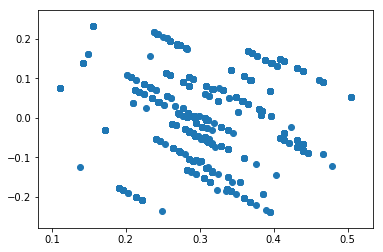

In [123]:
"""Test the first of these assumptions. Set first_assumption = True if it passed or False if it did not"""

### BEGIN SOLUTION
# Create a column of the residuals on training data
residuals = y_train - predictions_train

# Test homoscedascity -- good
# Note that the clusters of linear dots is due to trying to predict a country's MPI when the data for loans is at a more granular level
plt.scatter(y = residuals, x = predictions_train)
first_assumption = True
### END SOLUTION

'Test the second of these assumptions. Set second_assumption = True if it passed or False if it did not'

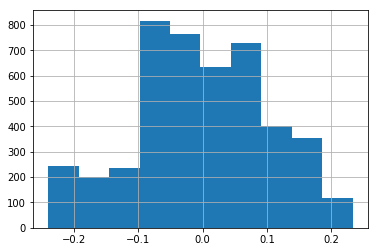

In [124]:
"""Test the second of these assumptions. Set second_assumption = True if it passed or False if it did not"""

### BEGIN SOLUTION
# Test normality of residuals -- good
residuals.hist()
second_assumption = True
### END SOLUTION

In [125]:
####################################INTENTIONALLY BLANK FOR TESTING####################################
### BEGIN HIDDEN TESTS
assert first_assumption == True
assert second_assumption == True
### END HIDDEN TESTS

## Improving the model

Clearly we have not captured all the independent variables necessary for a higher R2. Please describe other variables you would want to add to improve the model for predicting MPI. Describe where we could get that data.

***Example responses (but students would need to elaborate):***

* Life expectancy
* Child morality rates
* Literacy rates